In [50]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from scipy.stats import norm
from functools import partial
from datetime import datetime
from typing import Optional, Tuple

sns.set_theme(style="whitegrid")


class TensorNetwork:
    def __init__(self, graph, tensors):
        self.graph = graph
        self.tensors = tensors
        self.index_dims = {}
        self.index_to_tensors = {}
        for name, (tensor, indices) in tensors.items():
            for idx, dim in zip(indices, tensor.shape):
                if idx in self.index_dims:
                    assert self.index_dims[idx] == dim
                else:
                    self.index_dims[idx] = dim
                self.index_to_tensors.setdefault(idx, []).append((name, tensor, indices))
        self.col_of = {idx: c for c, idx in enumerate(self.index_dims)}


def evaluate_config(network: TensorNetwork, configs: np.ndarray) -> np.ndarray:
    out = np.ones(len(configs))
    for name, (tensor, inds) in network.tensors.items():
        keys = tuple(configs[:, network.col_of[i]] for i in inds)
        out *= tensor[keys]
    return np.clip(out, 1e-30, None)


def update_edge(network: TensorNetwork, configs: np.ndarray, idx: str, beta: float = 1.0):
    dim = network.index_dims[idx]
    col = network.col_of[idx]
    n_chains = configs.shape[0]
    probs = np.ones((n_chains, dim))
    # multiply in each tensor factor touching idx
    for _, tensor, inds in network.index_to_tensors[idx]:
        slc = [slice(None) if i == idx else configs[:, network.col_of[i]] for i in inds]
        vals = tensor[tuple(slc)]
        if vals.shape != (n_chains, dim):
            vals = vals.T
        probs *= np.clip(vals, 1e-30, None) ** beta
    probs /= probs.sum(axis=1, keepdims=True)
    # resample that index in all chains
    configs[:, col] = [
        np.random.choice(dim, p=probs[i]) for i in range(n_chains)
    ]


def estimate_contraction(
    net: TensorNetwork,
    betas: np.ndarray,
    iters: int = 20000,
    burns: int = 1900,
    n_chains: int = 10,
    verbose: bool = True
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Standard AIS: exactly one weight per chain per beta-step.
    Returns:
      Z_ests       – N_chains estimates of Z
      logZ_trajs   – list of length N_chains of log-Z trajectories
      weights_by_beta – array shape (K, N_chains) of incremental weights
    """
    K = len(betas) - 1
    index_list = list(net.index_dims)
    # initial random configurations
    configs = np.empty((n_chains, len(index_list)), dtype=int)
    for j, idx in enumerate(index_list):
        configs[:, j] = np.random.randint(0, net.index_dims[idx], size=n_chains)
    np.random.shuffle(configs.T)

    logZ_sums      = np.zeros(n_chains)
    logZ_trajs     = [ [] for _ in range(n_chains) ]
    weights_by_beta= np.zeros((K, n_chains))

    for k in range(1, len(betas)):
        b_prev, b_curr = betas[k-1], betas[k]
        db = b_curr - b_prev

        if verbose and (k % 10 == 0 or k == K):
            print(f"[{datetime.now().strftime('%H:%M:%S')}] β-step {k}/{K} (β={b_curr:.4f})")

        # 1) mix **all** chains under π_{β_prev}
        for t in range(iters):
            idx = np.random.choice(index_list)
            update_edge(net, configs, idx, beta=b_prev)

        # 2) one weight per chain
        psi_vals = evaluate_config(net, configs)                 # shape (n_chains,)
        w      = np.clip(psi_vals, 1e-30, None) ** db            # incremental weights
        log_w  = np.log(w)

        # record
        weights_by_beta[k-1,:] = w
        logZ_sums += log_w
        for j in range(n_chains):
            logZ_trajs[j].append(logZ_sums[j])

        if verbose:
            print(f"    ⟨w⟩ = {w.mean():.3e},   std(log w) = {np.std(log_w):.3e}")

    # finish
    logZ0 = np.sum(np.log(list(net.index_dims.values())))
    Z_ests = np.exp(logZ_sums + logZ0)
    return Z_ests, np.array(logZ_trajs), weights_by_beta


def run_multiple_chains(
    tn: TensorNetwork,
    betas: np.ndarray,
    iters: int=20000,
    burns: int=1900,
    n_chains: int=10,
    verbose: bool=True,
    Z_true: float=None
) -> Tuple[float, float]:
    Z_ests, logZ_trajs, w_by_beta = estimate_contraction(
        tn, betas, iters=iters, burns=burns, n_chains=n_chains, verbose=verbose
    )

    # simple diagnostics
    # … you can reuse your run_diagnostics, adapting it to w_by_beta[k] being shape (n_chains,)
    return Z_ests.mean(), Z_ests.std(ddof=1)

In [51]:
def test_trace_ABCD(dim=3,
                    n_betas=200,
                    n_chains=10,
                    iters=20000,
                    burns=10000):
    print("\n>>> Building 2x2 ring tensor network (Tr(ABCD))")

    G = nx.Graph()
    G.add_edges_from([
        ('A', 'B'), ('B', 'C'),
        ('C', 'D'), ('D', 'A'),
    ])

    tensors = {}
    index_order = {
        'A': ['i', 'j'],
        'B': ['j', 'k'],
        'C': ['k', 'l'],
        'D': ['l', 'i']
    }
    for node, inds in index_order.items():
        data = np.random.normal(loc=1.0, scale=0.01, size=(dim, dim)) + 1e-6
        tensors[node] = (data, inds)

    A, B, C, D = [tensors[k][0] for k in ['A', 'B', 'C', 'D']]
    TRUE_Z = np.einsum('ij,jk,kl,li->', A, B, C, D)
    print(f"True Z (Tr(ABCD)): {TRUE_Z:.6f}")

    tn = TensorNetwork(G, tensors)
    betas = np.linspace(0, 1, n_betas)

    print("\n>>> Running AIS estimation...")
    mean_Z, std_Z = run_multiple_chains(
        tn, betas,
        n_chains=n_chains,
        iters=iters,
        burns=burns,
        Z_true=TRUE_Z
    )

    rel_error = abs(mean_Z - TRUE_Z) / abs(TRUE_Z)
    print("\n================== Final Summary ==================")
    print(f"True        Z  : {TRUE_Z:.12f}")
    print(f"Estimated   Z  : {mean_Z:.12f} ± {std_Z:.12f}")
    print(f"Relative Error : {rel_error:.12e}")
    print("====================================================")

# test_trace_ABCD()

In [52]:
def contract_tensor_network(graph, tensors):
    # build einsum expression from tensor network
    einsum_terms = []
    einsum_tensors = []
    index_map = {}
    chars = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')

    for _, (tensor, indices) in tensors.items():
        subs = []
        for idx in indices:
            if idx not in index_map:
                index_map[idx] = chars.pop(0)
            subs.append(index_map[idx])
        einsum_terms.append(''.join(subs))
        einsum_tensors.append(tensor)

    expr = ','.join(einsum_terms) + '->'
    return np.einsum(expr, *einsum_tensors)

def build_3x3_grid_test(dim=3, variance=0.1):
    # construct 3x3 grid tensor network
    np.random.seed(42)
    G = nx.Graph()
    tensors = {}
    grid_size = 3
    node_names = {(i, j): f"T{i}{j}" for i in range(grid_size) for j in range(grid_size)}

    def edge_index(i1, j1, i2, j2):
        return f"{i1}{j1}_{i2}{j2}"

    for i in range(grid_size):
        for j in range(grid_size):
            name = node_names[(i, j)]
            neighbors = []

            if j + 1 < grid_size:
                nbr = node_names[(i, j+1)]
                idx = edge_index(i, j, i, j+1)
                G.add_edge(name, nbr)
                neighbors.append(idx)
            if i + 1 < grid_size:
                nbr = node_names[(i+1, j)]
                idx = edge_index(i, j, i+1, j)
                G.add_edge(name, nbr)
                neighbors.append(idx)
            if j > 0:
                neighbors.append(edge_index(i, j-1, i, j))
            if i > 0:
                neighbors.append(edge_index(i-1, j, i, j))

            neighbors = sorted(neighbors)
            shape = (dim,) * len(neighbors)
            tensor = np.random.normal(loc=1.0, scale=variance, size=shape) + 1e-6
            tensor /= np.linalg.norm(tensor)  # normalize tensor
            # tensor = np.random.normal(loc=1.0, scale=0.01, size=(dim, dim)) + 1e-6
            tensors[name] = (tensor, neighbors)

    return G, tensors

def test_trace_3x3_grid(dim=3,
                        n_betas=100,
                        n_chains=5,
                        iters=20000,
                        burns=1900):
    # test ais on 3x3 grid tensor network using quadratic beta schedule
    print("\n>>> building 3x3 tensor network")
    G, tensors = build_3x3_grid_test(dim=dim)
    TRUE_Z = contract_tensor_network(G, tensors)
    print(f"true Z (exact contraction): {TRUE_Z:.6f}")

    tn = TensorNetwork(G, tensors)
    betas = np.linspace(0, 1, n_betas)

    print("\n>>> running ais with quadratic beta schedule")
    mean_Z, std_Z = run_multiple_chains(
        tn, betas,
        n_chains=n_chains,
        iters=iters,
        burns=burns,
        Z_true=TRUE_Z
    )

    rel_error = abs(mean_Z - TRUE_Z) / abs(TRUE_Z)
    print("\n================== final summary ==================")
    print(f"true        Z  : {TRUE_Z:.12f}")
    print(f"estimated   Z  : {mean_Z:.12f} ± {std_Z:.12f}")
    print(f"relative error : {rel_error:.6e}")
    print("====================================================")

def contract_tensor_network(graph, tensors):
    einsum_terms = []
    einsum_tensors = []
    index_map = {}
    chars = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')

    for _, (tensor, indices) in tensors.items():
        subs = []
        for idx in indices:
            if idx not in index_map:
                if not chars:
                    raise ValueError("ran out of characters for einsum indices")
                index_map[idx] = chars.pop(0)
            subs.append(index_map[idx])
        einsum_terms.append(''.join(subs))
        einsum_tensors.append(tensor)

    expr = ','.join(einsum_terms) + '->'
    return np.einsum(expr, *einsum_tensors, optimize='greedy')

def build_3x3_grid_diagonally_dominant(dim=3, noise_level=0.1):
    np.random.seed(42)
    G = nx.Graph()
    tensors = {}
    grid_size = 3
    node_names = {(i, j): f"T{i}{j}" for i in range(grid_size) for j in range(grid_size)}

    def edge_index(i1, j1, i2, j2):
        return "_".join(sorted([f"{i1}{j1}", f"{i2}{j2}"]))

    for i in range(grid_size):
        for j in range(grid_size):
            name = node_names[(i, j)]
            
            physical_neighbors = []
            if i > 0: physical_neighbors.append((i - 1, j))
            if i < grid_size - 1: physical_neighbors.append((i + 1, j))
            if j > 0: physical_neighbors.append((i, j - 1))
            if j < grid_size - 1: physical_neighbors.append((i, j + 1))

            indices = sorted([edge_index(i,j, ni,nj) for ni,nj in physical_neighbors])
            G.add_node(name)
            for ni, nj in physical_neighbors:
                 G.add_edge(name, node_names[(ni,nj)])
            
            shape = (dim,) * len(indices)
            rank = len(shape)

            diagonal_part = np.zeros(shape)
            for k in range(dim):
                idx = (k,) * rank 
                diagonal_part[idx] = 1.0

            noise_part = np.ones(shape)
            
            dominance_factor = 1.0 - noise_level
            tensor = diagonal_part * dominance_factor + noise_part * (noise_level / dim**rank)

            # tensor /= np.linalg.norm(tensor)
            tensors[name] = (tensor, indices)

    return G, tensors

# run test
# test_trace_3x3_grid()

In [53]:
def naive_mc_estimate(
    net: TensorNetwork,
    num_samples: int,
    Z_true: float = None,
    seed: int = None
):
    """
    Naive Monte Carlo estimate of Z = sum_x ψ(x) for a tensor network.

    Args:
        net:       A TensorNetwork instance.
        num_samples: Number of uniform samples to draw.
        Z_true:    (Optional) Exact Z, for logging only.
        seed:      RNG seed.

    Returns:
        mc_estimate: float, the MC estimate of Z.
        mc_std_err:  float, the standard error of the estimate.
        mc_values:   ndarray of shape (num_samples,), each sample's contribution M*ψ(x).
    """
    rng = np.random.RandomState(seed)
    # list of all index names and their dimensions
    idx_list = list(net.index_dims.keys())
    dims = [net.index_dims[idx] for idx in idx_list]

    # draw uniform samples: configs shape (num_samples, n_vars)
    # by sampling each coordinate independently
    configs = np.stack([
        rng.randint(0, d, size=num_samples)
        for d in dims
    ], axis=1)

    # evaluate unnormalized weight ψ(x) for each sample
    psi_vals = evaluate_config(net, configs)
    psi_vals = np.clip(psi_vals, 1e-30, None)

    # scale by total number of configurations M = ∏ dim_i
    M = np.prod(dims)
    mc_values = M * psi_vals

    # MC estimate and standard error
    mc_estimate = mc_values.mean()
    mc_std_err = mc_values.std(ddof=1) / np.sqrt(num_samples)

    return mc_estimate, mc_std_err, mc_values

def run_noise_sweep(
    noise_levels,
    dim=3,
    n_betas=100,
    n_chains=5,
    iters=20000,
    burns=1900,
    mc_samples=10000
):
    rows = []
    for noise in noise_levels:
        print(f"\n>>> running trial with noise_level = {noise:.3f}")
        G, tensors = build_3x3_grid_diagonally_dominant(dim=dim, noise_level=noise)
        TRUE_Z = contract_tensor_network(G, tensors)
        tn = TensorNetwork(G, tensors)
        betas = np.linspace(0, 1, n_betas)

        # AIS
        Z_ais, _, _ = estimate_contraction(
            tn, betas, iters, burns,
            n_chains=n_chains, verbose=False
        )
        ais_mean, ais_std = Z_ais.mean(), Z_ais.std(ddof=1)
        ais_sem = ais_std / np.sqrt(len(Z_ais))
        ais_rel = abs(ais_mean - TRUE_Z) / abs(TRUE_Z)

        # Naive Monte Carlo
        mc_estimate, _, mc_values = naive_mc_estimate(
            tn, num_samples=mc_samples,
            Z_true=TRUE_Z, seed=42
        )
        mc_std = mc_values.std(ddof=1)
        mc_sem = mc_std / np.sqrt(len(mc_values))
        mc_rel = abs(mc_estimate - TRUE_Z) / abs(TRUE_Z)

        rows.append({
            "noise_level": noise,
            "method": "AIS",
            "sem": ais_sem,
            "rel_error": ais_rel
        })
        rows.append({
            "noise_level": noise,
            "method": "Naive MC",
            "sem": mc_sem,
            "rel_error": mc_rel
        })

    return pd.DataFrame(rows)

def test_compare_ais_vs_naive_mc_diagdom(
    dim=3,
    noise_levels=(0.001, 0.005, 0.01, 0.05, 0.1),
    n_betas=100,
    n_chains=5,
    iters=20000,
    burns=1900,
    mc_samples=10000
):
    # Sweep over diagonally‐dominant noise levels
    df = run_noise_sweep(
        noise_levels=noise_levels,
        dim=dim,
        n_betas=n_betas,
        n_chains=n_chains,
        iters=iters,
        burns=burns,
        mc_samples=mc_samples
    )

    # Plot
    sns.set_theme(style="whitegrid", font_scale=1.2)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    # Relative error vs noise
    sns.lineplot(
        data=df,
        x="noise_level",
        y="rel_error",
        hue="method",
        marker="o",
        ax=ax1
    )
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_xlabel("Diagonal‐dominant noise level")
    ax1.set_ylabel("Mean relative error")
    ax1.set_title("Relative Error vs Noise Level")

    # SEM vs noise
    sns.lineplot(
        data=df,
        x="noise_level",
        y="sem",
        hue="method",
        marker="o",
        ax=ax2
    )
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax2.set_xlabel("Diagonal‐dominant noise level")
    ax2.set_ylabel("Standard error (SEM)")
    ax2.set_title("Estimator SEM vs Noise Level")

    plt.tight_layout()
    plt.show()

# Example:
# test_compare_ais_vs_naive_mc_diagdom()

In [54]:
def test_trace_diagonal_ABCD(dim=3,
                             n_betas=200,
                             n_chains=10,
                             iters=20000,
                             burns=10000):
    print("\n>>> Building 2x2 diagonal tensor network (Tr(ABCD))")

    G = nx.Graph()
    G.add_edges_from([
        ('A', 'B'), ('B', 'C'),
        ('C', 'D'), ('D', 'A'),
    ])

    tensors = {}
    index_order = {
        'A': ['i', 'j'],
        'B': ['j', 'k'],
        'C': ['k', 'l'],
        'D': ['l', 'i']
    }
    for node, inds in index_order.items():
        data = np.eye(dim) * 0.9 + np.ones((dim, dim)) * 0.1 / dim  # diagonal tensor with small noise
        data /= np.linalg.norm(data)  # normalize tensor
        tensors[node] = (data, inds)

    A, B, C, D = [tensors[k][0] for k in ['A', 'B', 'C', 'D']]
    TRUE_Z = np.einsum('ij,jk,kl,li->', A, B, C, D)
    print(f"True Z (Tr(ABCD)): {TRUE_Z:.6f}")

    tn = TensorNetwork(G, tensors)
    betas = np.linspace(0, 1, n_betas)

    print("\n>>> Running AIS estimation...")
    mean_Z, std_Z = run_multiple_chains(
        tn, betas,
        n_chains=n_chains,
        iters=iters,
        burns=burns,
        Z_true=TRUE_Z
    )

    rel_error = abs(mean_Z - TRUE_Z) / abs(TRUE_Z)
    print("\n================== Final Summary ==================")
    print(f"True        Z  : {TRUE_Z:.12f}")
    print(f"Estimated   Z  : {mean_Z:.12f} ± {std_Z:.12f}")
    print(f"Relative Error : {rel_error:.12e}")
    print("====================================================")

# test_trace_diagonal_ABCD(dim=3,
#                           n_betas=200,
#                           n_chains=10,
#                           iters=20000,
#                           burns=10000)

In [55]:
def contract_tensor_network(graph, tensors):
    einsum_terms = []
    einsum_tensors = []
    index_map = {}
    chars = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')

    for _, (tensor, indices) in tensors.items():
        subs = []
        for idx in indices:
            if idx not in index_map:
                if not chars:
                    raise ValueError("ran out of characters for einsum indices")
                index_map[idx] = chars.pop(0)
            subs.append(index_map[idx])
        einsum_terms.append(''.join(subs))
        einsum_tensors.append(tensor)

    expr = ','.join(einsum_terms) + '->'
    return np.einsum(expr, *einsum_tensors, optimize='greedy')

def build_3x3_grid_diagonally_dominant(dim=3, noise_level=0.1):
    np.random.seed(42)
    G = nx.Graph()
    tensors = {}
    grid_size = 3
    node_names = {(i, j): f"T{i}{j}" for i in range(grid_size) for j in range(grid_size)}

    def edge_index(i1, j1, i2, j2):
        return "_".join(sorted([f"{i1}{j1}", f"{i2}{j2}"]))

    for i in range(grid_size):
        for j in range(grid_size):
            name = node_names[(i, j)]
            
            physical_neighbors = []
            if i > 0: physical_neighbors.append((i - 1, j))
            if i < grid_size - 1: physical_neighbors.append((i + 1, j))
            if j > 0: physical_neighbors.append((i, j - 1))
            if j < grid_size - 1: physical_neighbors.append((i, j + 1))

            indices = sorted([edge_index(i,j, ni,nj) for ni,nj in physical_neighbors])
            G.add_node(name)
            for ni, nj in physical_neighbors:
                 G.add_edge(name, node_names[(ni,nj)])
            
            shape = (dim,) * len(indices)
            rank = len(shape)

            diagonal_part = np.zeros(shape)
            for k in range(dim):
                idx = (k,) * rank 
                diagonal_part[idx] = 1.0

            noise_part = np.ones(shape)
            
            dominance_factor = 1.0 - noise_level
            tensor = diagonal_part * dominance_factor + noise_part * (noise_level / dim**rank)

            # tensor /= np.linalg.norm(tensor)
            tensors[name] = (tensor, indices)

    return G, tensors

# test ais on 3x3 diagonally-dominant grid tensor network
def test_trace_3x3_grid_dd(dim=3,
                           n_betas=150,
                           n_chains=30,
                           iters=20000,
                           burns=10000):
    print("\n>>> building 3x3 diagonally-dominant tensor network")
    G, tensors = build_3x3_grid_diagonally_dominant(dim=dim, noise_level=0.1)
    
    print(">>> performing exact contraction")
    TRUE_Z = contract_tensor_network(G, tensors)
    print(f"true z (exact contraction): {TRUE_Z:.12f}")

    tn = TensorNetwork(G, tensors)
    betas = np.linspace(0, 1, n_betas)**2

    print("\n>>> running ais estimation...")
    mean_Z, std_Z = run_multiple_chains(
        tn, betas,
        n_chains=n_chains,
        iters=iters,
        burns=burns,
        Z_true=TRUE_Z,
    )

    rel_error = abs(mean_Z - TRUE_Z) / abs(TRUE_Z) if TRUE_Z != 0 else float('inf')
    print("\n================== final summary ==================")
    print(f"true        z  : {TRUE_Z:.12f}")
    print(f"estimated   z  : {mean_Z:.12f} ± {std_Z:.12f}")
    print(f"relative error : {rel_error:.6e}")
    print("====================================================")

# run test
# test_trace_3x3_grid_dd()

In [56]:
def test_rw_uniform_sample_efficiency(dim=3, n_betas=200, burns=2000, sample_sizes=[100, 500, 1000, 2000, 5000, 10000, 20000], target_error=0.01, n_chains=10):
    print('\n>>> building 2x2 diagonally-dominant tensor network for random walk vs uniform sampling efficiency test')
    G = nx.Graph()
    G.add_edges_from([
        ('A', 'B'), ('B', 'C'),
        ('C', 'D'), ('D', 'A'),
    ])

    tensors = {}
    index_order = {
        'A': ['i', 'j'],
        'B': ['j', 'k'],
        'C': ['k', 'l'],
        'D': ['l', 'i']
    }

    for node, inds in index_order.items():
        data = np.eye(dim) * 0.9 + np.ones((dim, dim)) * 0.1 / dim
        data /= np.linalg.norm(data)  # normalize tensor
        tensors[node] = (data, inds)
    
    A, B, C, D = [tensors[k][0] for k in ['A', 'B', 'C', 'D']]
    TRUE_Z = np.einsum('ij,jk,kl,li->', A, B, C, D)
    print(f"True Z (Tr(ABCD)): {TRUE_Z:.6f}")
    
    tn = TensorNetwork(G, tensors)
    betas = np.linspace(0, 1, n_betas)
    results = {'samples': [], 'Uniform': [], 'AIS': []}

    for n_samples in sample_sizes:
        iters = n_samples
        burn_in = max(int(iters * 0.1), 50)  # ensure burns is at least 10% of samples
        print(f'\n --- Testing with {n_samples} samples --- ')

        # uniform sampling (no walkers)
        est_u, std_u, _ = naive_mc_estimate(tn, num_samples=iters*n_chains, Z_true=TRUE_Z, seed=42)
        rel_error_u = abs(est_u - TRUE_Z) / abs(TRUE_Z) if TRUE_Z != 0 else float('inf')

        # random walk-AIS sampling
        est_rw, std_rw = run_multiple_chains(
            tn, betas,
            n_chains=n_chains,
            iters=n_samples,
            burns=burn_in,
            Z_true=TRUE_Z
        )
        rel_error_rw = abs(est_rw - TRUE_Z) / abs(TRUE_Z) if TRUE_Z != 0 else float('inf')

        results['samples'].append(n_samples)
        results['Uniform'].append(rel_error_u)
        results['AIS'].append(rel_error_rw)

    df = pd.DataFrame({
        'Samples per Chain': results['samples'] * 2,
        'Relative Error': results['Uniform'] + results['AIS'],
        'Method': ['Uniform'] * len(results['samples']) + ['AIS (Random Walk)'] * len(results['samples'])
    })

    sns.set_theme(style='whitegrid', font_scale=1.3)
    plt.figure(figsize=(8, 5))
    palette = sns.color_palette('tab10', 2)
    sns.lineplot(
        data=df,
        x='Samples per Chain',
        y='Relative Error',
        hue='Method',
        style='Method',
        markers=True,
        dashes=False,
        lw=2.3,
        markersize=9,
        marker='o',
        palette=palette
    )
    plt.yscale('log')
    plt.ylabel('Relative Error (log)')
    plt.title('Sample Efficiency: Uniform vs AIS (Random Walk)')
    plt.legend(title='Sampling Method')
    plt.tight_layout()
    plt.show()

# test_rw_uniform_sample_efficiency(
#     dim=3,
#     n_betas=200,
#     burns=2000,
#     sample_sizes=[100, 500, 1000, 2000, 5000, 10000, 20000],
#     target_error=0.01,
#     n_chains=10
# )

In [57]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

# from your_module import TensorNetwork, evaluate_config, update_edge  # adjust import

sns.set_theme(style='whitegrid', font_scale=1.3)

def test_rw_uniform_sample_efficiency_local(
    dim=3,
    beta_prev=0.4,
    beta_next=0.41,
    sample_sizes=[100, 500, 1000, 2000, 5000, 10000],
    n_trials=20
):
    """
    For each total-sample budget S in sample_sizes, compare:
      - Uniform: draw S independent configs, weight^Δβ, take mean + SEM
      - AIS/RW: run S independent MCMC chains, each mixing for burn_in steps under π_{β_prev},
                take one sample from each chain, weight^Δβ, then mean + SEM.
    """
    # build 2×2 TN
    G = nx.Graph()
    G.add_edges_from([('A','B'),('B','C'),('C','D'),('D','A')])
    idx_order = {'A':['i','j'],'B':['j','k'],'C':['k','l'],'D':['l','i']}
    tensors = {}
    for node, inds in idx_order.items():
        M = np.eye(dim)*0.9 + np.ones((dim,dim))*(0.1/dim)
        M /= np.linalg.norm(M)
        tensors[node] = (M, inds)
    tn = TensorNetwork(G, tensors)

    # exact Z and ratio
    A,B,C,D = (tensors[n][0] for n in ['A','B','C','D'])
    Z0 = np.einsum('ij,jk,kl,li->', A, B, C, D)
    Z1 = Z0**1  # we only need Z0 here since ratio from sampling
    delta_beta = beta_next - beta_prev

    records = []

    for S in sample_sizes:
        sems_u = []
        sems_rw = []
        errs_u = []
        errs_rw = []

        burn_in = max(int(0.1 * S), 50)

        for _ in range(n_trials):
            # --- Uniform sampling: S independent draws ---
            X = np.random.randint(0, dim, size=(S, len(tn.index_dims)))
            ps = evaluate_config(tn, X)
            ps = np.clip(ps, 1e-30, None)
            w_u = ps**delta_beta
            est_u = w_u.mean()
            sem_u = w_u.std(ddof=1)/np.sqrt(S)
            relerr_u = abs(est_u - (Z1/Z0)) / (Z1/Z0)

            # --- AIS / Random‐walk: S independent chains, one sample each ---
            # initialize S chains
            cfg = np.random.randint(0, dim, size=(S, len(tn.index_dims)))
            # burn‐in
            idx_list = list(tn.index_dims)
            for _ in range(burn_in):
                idx = np.random.choice(idx_list)
                update_edge(tn, cfg, idx, beta=beta_prev)
            # one more step to draw the actual sample from π_{β_prev}
            # (optional extra mixing step, can be omitted if burn_in is enough)
            idx = np.random.choice(idx_list)
            update_edge(tn, cfg, idx, beta=beta_prev)

            ps_rw = evaluate_config(tn, cfg)
            ps_rw = np.clip(ps_rw, 1e-30, None)
            w_rw = ps_rw**delta_beta
            est_rw = w_rw.mean()
            sem_rw = w_rw.std(ddof=1)/np.sqrt(S)
            relerr_rw = abs(est_rw - (Z1/Z0)) / (Z1/Z0)

            sems_u.append(sem_u)
            sems_rw.append(sem_rw)
            errs_u.append(relerr_u)
            errs_rw.append(relerr_rw)

        # average over trials
        records.append({
            'SamplesPerChain': S,
            'Uniform_Error': np.mean(errs_u),
            'Uniform_SEM':   np.mean(sems_u),
            'AIS_Error':     np.mean(errs_rw),
            'AIS_SEM':       np.mean(sems_rw),
        })

    df = pd.DataFrame(records)

    plt.figure(figsize=(8,5))
    for method, color in zip(['Uniform','AIS'], ['tab:orange','tab:blue']):
        err_col = f"{method}_Error"
        sem_col = f"{method}_SEM"
        plt.errorbar(
            df['SamplesPerChain'],
            df[err_col],
            yerr=df[sem_col],
            label=method + ' (±SEM)',
            marker='o',
            lw=2,
            capsize=3,
            color=color
        )

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Samples per Chain (or independent configs)")
    plt.ylabel("Mean Relative Error")
    plt.title(f"Sample Efficiency at β={beta_prev:.2f} → {beta_next:.2f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# test_rw_uniform_sample_efficiency_local()

In [58]:
def test_rw_vs_uniform_across_betas(
    dim=3,
    n_chains=10,
    n_samples=5000,
    beta_steps=np.linspace(0, 1, 101)  # steps of 0.01
):
    print('\n>>> Building 2x2 diagonally-dominant tensor network for full β sweep test')

    G = nx.Graph()
    G.add_edges_from([
        ('A', 'B'), ('B', 'C'),
        ('C', 'D'), ('D', 'A'),
    ])

    tensors = {}
    index_order = {
        'A': ['i', 'j'],
        'B': ['j', 'k'],
        'C': ['k', 'l'],
        'D': ['l', 'i']
    }

    for node, inds in index_order.items():
        data = np.eye(dim) * 0.9 + np.ones((dim, dim)) * 0.1 / dim
        data /= np.linalg.norm(data)  # normalize tensor
        tensors[node] = (data, inds)

    tn = TensorNetwork(G, tensors)
    TRUE_Z = np.einsum('ij,jk,kl,li->', *[tensors[k][0] for k in ['A', 'B', 'C', 'D']])
    print(f">>> True Z (Tr(ABCD)): {TRUE_Z:.6f}")

    results = {
        'beta': [],
        'Uniform_relerr': [],
        'AIS_relerr': [],
    }

    for i in range(len(beta_steps) - 1):
        beta_prev = beta_steps[i]
        beta_next = beta_steps[i + 1]
        delta_beta = beta_next - beta_prev

        print(f"\n>>> Beta step {i+1}/{len(beta_steps)-1}: β={beta_prev:.2f} → {beta_next:.2f} (Δβ={delta_beta:.4f})")

        burn_in = max(int(n_samples * 0.1), 50)

        psi_vals = []
        for _ in range(n_samples * n_chains):
            x = [np.random.randint(0, dim) for _ in tn.index_dims]
            config = np.array(x).reshape(1, -1)
            psi = evaluate_config(tn, config)[0]
            psi_vals.append(psi)

        psi_vals = np.clip(np.array(psi_vals), 1e-30, None)
        weights_uniform = psi_vals ** delta_beta
        estimate_u = np.mean(weights_uniform)
        std_u = np.std(weights_uniform, ddof=1) / np.sqrt(len(weights_uniform))  # SEM
        rel_error_u = std_u / estimate_u
        print(f"Uniform Estimate: {estimate_u:.6f} +/- {std_u:.6f} | Rel Error: {rel_error_u:.6%}")

        index_list = list(tn.index_dims)
        n_sites = len(index_list)

        configs = np.tile(np.arange(dim), (n_chains, int(np.ceil(n_sites / dim))))[:, :n_sites]
        np.random.shuffle(configs.T)

        for t in range(burn_in):
            idx = np.random.choice(index_list)
            update_edge(tn, configs, idx, beta=beta_prev)

        weights = []
        for _ in range(n_samples):
            for idx in index_list:
                update_edge(tn, configs, idx, beta=beta_prev)

            psi_vals = evaluate_config(tn, configs)
            w = np.clip(psi_vals, 1e-30, None) ** delta_beta
            weights.append(w)

        weights = np.array(weights)  # shape (n_samples, n_chains)
        weights_mean = weights.mean(axis=0)  # mean over samples for each chain

        estimate_rw = np.mean(weights_mean)
        std_rw = np.std(weights_mean, ddof=1) / np.sqrt(n_chains)  # SEM over chains
        rel_error_rw = std_rw / estimate_rw
        print(f"Random Walk Estimate: {estimate_rw:.6f} +/- {std_rw:.6f} | Rel Error: {rel_error_rw:.6%}")

        results['beta'].append(beta_prev)
        results['Uniform_relerr'].append(rel_error_u)
        results['AIS_relerr'].append(rel_error_rw)

    df = pd.DataFrame({
        'Beta': results['beta'] * 2,
        'Relative Error': results['Uniform_relerr'] + results['AIS_relerr'],
        'Method': ['Uniform'] * len(results['beta']) + ['AIS (Random Walk)'] * len(results['beta'])
    })

    sns.set_theme(style='whitegrid', font_scale=1.3)
    plt.figure(figsize=(9, 5))
    sns.lineplot(
        data=df,
        x='Beta',
        y='Relative Error',
        hue='Method',
        style='Method',
        markers=True,
        dashes=False,
        lw=2.5,
        markersize=8
    )
    plt.yscale('log')
    plt.xlabel('Beta')
    plt.ylabel('Relative Error (log)')
    plt.title(f'Relative Error vs Beta | Samples={n_samples} per chain')
    plt.legend(title='Sampling Method')
    plt.tight_layout()
    plt.show()


# run
# test_rw_vs_uniform_across_betas(
#     dim=3,
#     n_chains=10,
#     n_samples=5000,
#     beta_steps=np.linspace(0, 1, 101)
# )

In [59]:
def test_rw_vs_uniform_across_betas_3x3(
    dim=3,
    n_chains=10,
    n_samples=5000,
    beta_steps=np.linspace(0, 1, 150),
    n_trials=20,
    seed=42
):
    import numpy as _np
    import pandas as _pd
    import matplotlib.pyplot as _plt
    import seaborn as _sns
    from scipy.stats import norm

    _np.random.seed(seed)
    z_score = norm.ppf(0.975)

    G, tensors = build_3x3_grid_diagonally_dominant(dim=dim, noise_level=0.1)
    tn = TensorNetwork(G, tensors)

    idx_list = list(tn.index_dims.keys())
    _dim = dim
    _eval = evaluate_config
    _update = update_edge

    # cache exact contractions
    _cache = {}
    def contract_at_beta(beta):
        if beta not in _cache:
            tempered = {
                node: (_np.clip(T, 1e-30, None) ** beta, inds)
                for node, (T, inds) in tensors.items()
            }
            _cache[beta] = contract_tensor_network(G, tempered)
        return _cache[beta]

    # precomputed burn-in update indices
    burn = max(int(0.1 * n_samples), 1)
    burn_idxs = _np.random.choice(idx_list, size=burn, replace=True)

    records = []
    for i in range(len(beta_steps) - 1):
        b0, b1 = beta_steps[i], beta_steps[i+1]
        db = b1 - b0

        Z0 = contract_at_beta(b0)
        Z1 = contract_at_beta(b1)
        true_ratio = Z1 / Z0
        print(f">>> True ratio Z({b1:.2f})/Z({b0:.2f}) = {true_ratio:.6g}")

        errs_u = _np.empty(n_trials)
        errs_rw = _np.empty(n_trials)

        for t in range(n_trials):
            # uniform
            X = _np.random.randint(0, _dim, size=(n_samples, len(idx_list)))
            psi = _eval(tn, X)
            psi = _np.clip(psi, 1e-30, None)
            Zb0_hat = (psi ** b0).mean()
            Zb1_hat = (psi ** b1).mean()
            rho_u = Zb1_hat / Zb0_hat
            errs_u[t] = abs(rho_u - true_ratio) / abs(true_ratio)

            # AIS, one sample per chain after mixing
            cfg = _np.random.randint(0, _dim, size=(n_chains, len(idx_list)))
            for idx in burn_idxs:
                _update(tn, cfg, idx, beta=b0)
            psi_rw = _eval(tn, cfg)
            psi_rw = _np.clip(psi_rw, 1e-30, None)
            rho_rw = (psi_rw ** db).mean()
            errs_rw[t] = abs(rho_rw - true_ratio) / abs(true_ratio)

        def geom_stats(x, z_score=1.96):
            logx = _np.log(x + 1e-20)
            mean_log = logx.mean()
            se_log = logx.std(ddof=1) / _np.sqrt(len(x))
            geom_mean = _np.exp(mean_log)
            lower = _np.exp(mean_log - z_score * se_log)
            upper = _np.exp(mean_log + z_score * se_log)
            se_geom = (upper - lower) / 2
            return geom_mean, se_geom

        gm_u, se_u = geom_stats(errs_u, z_score)
        gm_rw, se_rw = geom_stats(errs_rw, z_score)

        print(f"at β={b0:.2f} (Δβ={db:.4f}): "
              f"Uniform {gm_u:.3%}±{se_u:.3%}, "
              f"AIS {gm_rw:.3%}±{se_rw:.3%}")

        records.extend([
            (b0, gm_u, se_u, "Uniform Sampling"),
            (b0, gm_rw, se_rw, "AIS (1-sample per chain)")
        ])

    df = _pd.DataFrame(records, columns=["Beta", "GeomMeanErr", "SE", "Method"])
    _sns.set_theme(style="whitegrid", font_scale=1.2)
    fig, ax = _plt.subplots(figsize=(8, 5))

    for method, grp in df.groupby("Method"):
        err = grp["SE"]
        ax.fill_between(
            grp["Beta"],
            grp["GeomMeanErr"] - err,
            grp["GeomMeanErr"] + err,
            alpha=0.2,
            label=f"{method} ± SE"
        )
        ax.plot(
            grp["Beta"], grp["GeomMeanErr"],
            marker='o',
            linewidth=2.5 if "AIS" in method else 1.5,
            markersize=6,
            label=method
        )

    # mark crossover
    uni = df[df.Method == "Uniform Sampling"].sort_values("Beta")["GeomMeanErr"].values
    rw  = df[df.Method == "AIS (1-sample per chain)"].sort_values("Beta")["GeomMeanErr"].values
    betas = _np.sort(df["Beta"].unique())
    ix = _np.argmin(_np.abs(uni - rw))
    ax.axvline(betas[ix], color='gray', linestyle='--', linewidth=1)
    ax.plot(betas[ix], uni[ix], 'o', color='gray', markersize=5)

    ax.set_yscale('log')
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel("Geometric Mean Relative Error")
    ax.set_title(f"Uniform vs AIS Relative Error Across β (3×3 TN, {n_samples} samples)")
    ax.legend()
    fig.tight_layout()
    _plt.show()

# test_rw_vs_uniform_across_betas_3x3()

In [60]:
def test_rw_vs_uniform_efficiency_3x3(
    dim=3,
    sample_sizes=[100, 500, 1000, 2000, 5000, 10000, 20000, 50000],
    n_chains=10
):
    print("\n>>> Building 3x3 diagonally-dominant tensor network for efficiency test")

    G, tensors = build_3x3_grid_diagonally_dominant(dim=dim, noise_level=0.1)
    tn = TensorNetwork(G, tensors)

    TRUE_Z = contract_tensor_network(G, tensors)
    print(f">>> True Z (exact contraction): {TRUE_Z:.6f}")

    results = {
        'Samples': [],
        'Method': [],
        'Relative Error': []
    }

    for n_samples in sample_sizes:
        burn_in = max(int(n_samples * 0.1), 50)
        print(f'\n --- Testing with {n_samples} samples --- ')

        psi_vals = []
        for _ in range(n_samples * n_chains):
            x = [np.random.randint(0, dim) for _ in tn.index_dims]
            config = np.array(x).reshape(1, -1)
            psi = evaluate_config(tn, config)[0]
            psi_vals.append(psi)

        psi_vals = np.clip(np.array(psi_vals), 1e-30, None)
        volume = np.prod([dim] * len(tn.index_dims))
        estimate_u = np.mean(psi_vals) * volume
        std_u = (np.std(psi_vals, ddof=1) / np.sqrt(len(psi_vals))) * volume
        rel_error_u = std_u / estimate_u
        print(f"Naive MC Estimate: {estimate_u:.6f} +/- {std_u:.6f} | Rel Error: {rel_error_u:.6%}")

        results['Samples'].append(n_samples)
        results['Method'].append('NaiveMC')
        results['Relative Error'].append(rel_error_u)

        Z_rw, _, _ = estimate_contraction(
            tn,
            betas=np.linspace(0, 1, 200),
            iters=n_samples,
            burns=burn_in,
            n_chains=n_chains,
            verbose=False
        )
        estimate_rw = np.mean(Z_rw)
        std_rw = np.std(Z_rw, ddof=1) / np.sqrt(n_chains)
        rel_error_rw = std_rw / estimate_rw
        print(f"AIS Estimate: {estimate_rw:.6f} +/- {std_rw:.6f} | Rel Error: {rel_error_rw:.6%}")

        results['Samples'].append(n_samples)
        results['Method'].append('AIS')
        results['Relative Error'].append(rel_error_rw)

    df = pd.DataFrame(results)

    sns.set_theme(style='whitegrid', font_scale=1.35)
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=df,
        x='Samples',
        y='Relative Error',
        hue='Method',
        marker='o',
        lw=2.5
    )
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Samples (log)')
    plt.ylabel('Relative Error (log)')
    plt.title('Relative Error vs Samples | 3x3 Diagonal-Dominant Grid')
    plt.tight_layout()
    plt.show()


# run the test
# test_rw_vs_uniform_efficiency_3x3(
#     dim=3,
#     sample_sizes=[100, 500, 1000, 2000, 5000, 10000, 20000, 50000],
#     n_chains=10
# )

In [61]:
def test_scaling_vs_dimension_3x3(
    dims=[2, 3, 4, 5, 6, 7, 8],
    n_chains=10,
    n_betas=50,
    total_updates=40_000
):
    print("\n>>> Running AIS and Naive MC scaling test over tensor dimensions")

    results = {
        'Dimension': [],
        'Method': [],
        'Relative Error': []
    }

    for dim in dims:
        print(f"\n>>> Building 3x3 diagonally-dominant tensor network with dim={dim}")
        
        G, tensors = build_3x3_grid_diagonally_dominant(dim=dim, noise_level=0.1)
        tn = TensorNetwork(G, tensors)
        TRUE_Z = contract_tensor_network(G, tensors)
        print(f">>> True Z (exact contraction): {TRUE_Z:.6f}")

        psi_vals = []
        for _ in range(total_updates):
            x = [np.random.randint(0, tn.index_dims[idx]) for idx in tn.index_dims]
            config = np.array(x).reshape(1, -1)
            psi = evaluate_config(tn, config)[0]
            psi_vals.append(psi)

        psi_vals = np.clip(np.array(psi_vals), 1e-30, None)
        estimate_u = np.mean(psi_vals)
        std_u = np.std(psi_vals, ddof=1) / np.sqrt(len(psi_vals))
        rel_error_u = std_u / estimate_u
        print(f"Naive MC Estimate: {estimate_u:.6f} +/- {std_u:.6f} | Rel Error: {rel_error_u:.6%}")

        results['Dimension'].append(dim)
        results['Method'].append('NaiveMC')
        results['Relative Error'].append(rel_error_u)

        iters = max(total_updates // (n_betas - 1), 1)
        burn_in = max(int(iters * 0.1), 20)
        betas = np.linspace(0, 1, n_betas)

        Z_rw, _, _ = estimate_contraction(
            tn,
            betas=betas,
            iters=iters,
            burns=burn_in,
            n_chains=n_chains,
            verbose=False
        )

        estimate_rw = np.mean(Z_rw)
        std_rw = np.std(Z_rw, ddof=1) / np.sqrt(n_chains)
        rel_error_rw = std_rw / estimate_rw
        print(f"AIS Estimate: {estimate_rw:.6f} +/- {std_rw:.6f} | Rel Error: {rel_error_rw:.6%}")

        results['Dimension'].append(dim)
        results['Method'].append('AIS')
        results['Relative Error'].append(rel_error_rw)

    # ================= Plot =================
    df = pd.DataFrame(results)

    sns.set_theme(style='whitegrid', font_scale=1.35)
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=df,
        x='Dimension',
        y='Relative Error',
        hue='Method',
        marker='o',
        lw=2.5
    )
    plt.yscale('log')
    plt.xlabel('Tensor Dimension')
    plt.ylabel('Relative Error (log)')
    plt.title('Relative Error vs Tensor Dimension | 3x3 Diagonal-Dominant Grid')
    plt.tight_layout()
    plt.show()

# test_scaling_vs_dimension_3x3()

In [62]:
def contract_at_beta(graph, tensors, beta):
    """
    Raise each tensor entry to the power `beta`,
    then contract with your existing einsum-based function.
    """
    tempered = {}
    for name, (T, inds) in tensors.items():
        T2 = np.clip(T, 1e-30, None) ** beta
        tempered[name] = (T2, inds)
    return contract_tensor_network(graph, tempered)

def test_ais_error_vs_samples_walk_duration(
    dim=3,
    beta_prev=0.79,
    beta_curr=0.80,
    walk_durations=[0, 100, 10_000],
    sample_sizes=[50, 100, 150, 200, 500],
    n_trials=20
):
    delta = beta_curr - beta_prev

    G, tensors = build_3x3_grid_diagonally_dominant(dim=dim, noise_level=0.1)
    tn = TensorNetwork(G, tensors)

    Z_prev = contract_at_beta(G, tensors, beta_prev)
    Z_curr = contract_at_beta(G, tensors, beta_curr)
    true_ratio = Z_curr / Z_prev
    formatted_delta = f'{delta:.4f}'
    formatted_ratio = f'{true_ratio:.6f}'
    print(r">>> True single-step ratio: " + formatted_ratio + r"  ($\Delta \beta$ = " + formatted_delta + ")\n")

    results = {'Chains': [], 'Walk': [], 'MeanErr': [], 'StdErr': []}

    for walk in walk_durations:
        for N in sample_sizes:
            errs = []
            for _ in range(n_trials):
                weights = []
                for _ in range(N):
                    config = np.array([
                        np.random.randint(0, tn.index_dims[idx])
                        for idx in tn.index_dims
                    ]).reshape(1, -1)

                    for _ in range(walk):
                        idx = np.random.choice(list(tn.index_dims))
                        update_edge(tn, config, idx, beta=beta_prev)

                    ψ = evaluate_config(tn, config)[0]
                    weights.append(ψ**delta)

                ρ_hat = np.mean(weights)
                errs.append(abs(ρ_hat - true_ratio) / abs(true_ratio))

            mean_err = np.mean(errs)
            se     = np.std(errs, ddof=1) / np.sqrt(n_trials)
            print(f"Walk={walk:6d}, Chains={N:4d} --> Error={mean_err:.2%} ±{se:.2%}")

            results['Chains'].append(N)
            results['Walk'].append(f"{walk} steps")
            results['MeanErr'].append(mean_err)
            results['StdErr'].append(se)

    df = pd.DataFrame(results)
    sns.set_theme(style="whitegrid", font_scale=1.3)
    plt.figure(figsize=(8,5))
    sns.lineplot(
        data=df, x="Chains", y="MeanErr",
        hue="Walk", style="Walk",
        markers=True, dashes=False
    )
    # errorbars
    palette = sns.color_palette("tab10")
    for i, walk in enumerate(walk_durations):
        sub = df[df['Walk']==f"{walk} steps"]
        plt.errorbar(
            sub['Chains'], sub['MeanErr'],
            yerr=sub['StdErr'], fmt='none',
            capsize=3, color=palette[i]
        )

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Number of Chains (N)")
    plt.ylabel("Mean Relative Error")
    label = f"{delta:.4f}"
    plt.title(r"AIS ratio error vs. N at $\Delta \beta$ = " + label)
    plt.tight_layout()
    plt.show()

# test_ais_error_vs_samples_walk_duration()

In [63]:
def test_error_vs_samples_with_fixed_chains(
    dim=3,
    beta_prev=0.79,
    beta_curr=0.80,
    walk_durations=[0, 100, 10_000],
    sample_sizes=[5, 10, 20, 50, 100, 200],
    n_chains=10,
    n_trials=20,
):
    delta_beta = beta_curr - beta_prev

    G, tensors = build_3x3_grid_diagonally_dominant(dim=dim, noise_level=0.1)
    tn = TensorNetwork(G, tensors)
    Z_prev = contract_at_beta(G, tensors, beta_prev)
    Z_curr = contract_at_beta(G, tensors, beta_curr)
    true_ratio = Z_curr / Z_prev

    print(f">>> True single-step ratio: {true_ratio:.6f}  (Δβ={delta_beta:.4f})\n")

    results = {'SamplesPerChain': [], 'Walk': [], 'MeanErr': [], 'StdErr': []}

    for walk in walk_durations:
        for S in sample_sizes:
            trial_errs = []
            for _ in range(n_trials):
                # collect all weights across all chains and samples
                weights = []
                for _ in range(n_chains):
                    for _ in range(S):
                        config = np.array([
                            np.random.randint(0, tn.index_dims[idx])
                            for idx in tn.index_dims
                        ]).reshape(1, -1)
                        for _ in range(walk):
                            idx = np.random.choice(list(tn.index_dims))
                            update_edge(tn, config, idx, beta=beta_prev)

                        ψ = evaluate_config(tn, config)[0]
                        weights.append(ψ ** delta_beta)

                ρ_hat = np.mean(weights)
                trial_errs.append(abs(ρ_hat - true_ratio) / abs(true_ratio))

            mean_err = np.mean(trial_errs)
            se      = np.std(trial_errs, ddof=1) / np.sqrt(n_trials)
            print(f"Walk={walk:6d}, Samples/Chain={S:4d} → Error={mean_err:.2%} ±{se:.2%}")

            results['SamplesPerChain'].append(S)
            results['Walk'].append(f"{walk} steps")
            results['MeanErr'].append(mean_err)
            results['StdErr'].append(se)

    #error vs. samples per chain
    import pandas as pd
    df = pd.DataFrame(results)
    sns.set_theme(style="whitegrid", font_scale=1.3)
    plt.figure(figsize=(8,5))
    sns.lineplot(
        data=df, x="SamplesPerChain", y="MeanErr",
        hue="Walk", style="Walk",
        markers=True, dashes=False
    )
    palette = sns.color_palette("tab10")
    for i, walk in enumerate(walk_durations):
        sub = df[df['Walk']==f"{walk} steps"]
        plt.errorbar(
            sub['SamplesPerChain'], sub['MeanErr'],
            yerr=sub['StdErr'], fmt='none',
            capsize=3, color=palette[i]
        )

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Samples per Chain")
    plt.ylabel("Mean Relative Error")
    plt.title(f"AIS ratio error vs. samples per chain @ Δβ={delta_beta:.4f}")
    plt.tight_layout()
    plt.show()

# test_error_vs_samples_with_fixed_chains()

In [64]:
def test_trace_error_vs_chains_and_walks(
    dim=3,
    beta_prev=0.79,
    beta_curr=0.80,
    walk_durations=(0, 100, 10_000),
    n_chains_list=(5, 10, 25, 50, 100),
    burn_steps=100,
    n_trials=20,
    seed=42
):
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import networkx as nx
    from functools import partial

    np.random.seed(seed)
    delta_beta = beta_curr - beta_prev

    # --- Build a 2×2 ring TN (Tr(ABCD)) ---
    G = nx.Graph()
    G.add_edges_from([('A','B'), ('B','C'), ('C','D'), ('D','A')])
    # random 3×3 matrices
    mats = {n: np.random.rand(dim, dim) + 1e-6 for n in ('A','B','C','D')}
    idx_order = {'A':['i','j'], 'B':['j','k'], 'C':['k','l'], 'D':['l','i']}
    tensors = {n:(mats[n], inds) for n, inds in idx_order.items()}

    tn = TensorNetwork(G, tensors)
    index_list = list(tn.index_dims)

    _update = update_edge
    _eval   = evaluate_config
    contract = partial(contract_at_beta, G, tensors)

    # compute the true ratio for diagnostics
    Z_prev = contract(beta_prev)
    Z_curr = contract(beta_curr)
    true_ratio = Z_curr / Z_prev
    print(f">>> True single‐step ratio: {true_ratio:.6f}  (β={beta_prev:.2f}→{beta_curr:.2f})\n")

    # store results
    results = {
        'WalkLength': [],
        'Chains': [],
        'GeomMeanErr': [],
        'GeomStdErr': []
    }

    def geom_stats(errs, z=1.96):
        # errs: array of relative‐errors over trials
        loge = np.log(errs + 1e-20)
        m = loge.mean()
        se = loge.std(ddof=1) / np.sqrt(len(errs))
        gm = np.exp(m)
        # symmetric “SE” bar in linear scale
        lo = np.exp(m - z*se)
        hi = np.exp(m + z*se)
        return gm, (hi - lo)/2

    # sweep over walk lengths & number of chains
    for walk in walk_durations:
        for n_chains in n_chains_list:
            trial_errs = np.empty(n_trials, dtype=float)

            for t in range(n_trials):
                weights = []

                # run n_chains independent AIS “chain→walk→sample”
                for _ in range(n_chains):
                    # 1) random init
                    cfg = np.random.randint(0, dim, size=(1, len(index_list)))

                    # 2) burn‐in at β_prev
                    for __ in range(burn_steps):
                        idx = np.random.choice(index_list)
                        _update(tn, cfg, idx, beta=beta_prev)

                    # 3) walk length “walk” at β_prev
                    for __ in range(walk):
                        idx = np.random.choice(index_list)
                        _update(tn, cfg, idx, beta=beta_prev)

                    # 4) one sample
                    psi = _eval(tn, cfg)[0]
                    w   = np.clip(psi, 1e-30, None) ** delta_beta
                    weights.append(w)

                # estimator for this trial
                rho_hat = np.mean(weights)
                trial_errs[t] = abs(rho_hat - true_ratio) / abs(true_ratio)

            # compute geometric mean + sem of the relative‐error
            gm, sem = geom_stats(trial_errs, z=1.96)
            print(f"Walk={walk:5d}, Chains={n_chains:3d} → GeomErr={gm:.2%} ± {sem:.2%}")

            results['WalkLength'].append(f"{walk} steps")
            results['Chains'].append(n_chains)
            results['GeomMeanErr'].append(gm)
            results['GeomStdErr'].append(sem)

    # assemble DataFrame and plot
    df = pd.DataFrame(results)
    sns.set_theme(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(8,5))
    ax = sns.lineplot(
        data=df,
        x='Chains',
        y='GeomMeanErr',
        hue='WalkLength',
        style='WalkLength',
        markers=True,
        dashes=False,
        lw=2
    )

    # manual errorbars
    palette = sns.color_palette("tab10", len(walk_durations))
    for i, walk in enumerate(walk_durations):
        sub = df[df['WalkLength']==f"{walk} steps"]
        plt.errorbar(
            sub['Chains'], sub['GeomMeanErr'],
            yerr=sub['GeomStdErr'],
            fmt='none', capsize=3, color=palette[i]
        )

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Number of Chains (1 sample per chain)")
    ax.set_ylabel("Geometric Mean Relative Error")
    ax.set_title(f"Trace Estimation Error at β={beta_prev:.2f}→{beta_curr:.2f}")
    plt.tight_layout()
    plt.show()

# test_trace_error_vs_chains_and_walks()

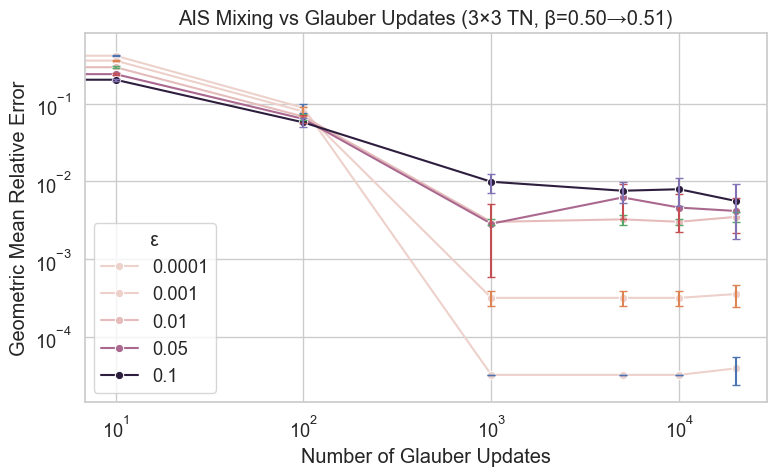

In [ ]:
def test_mixing_vs_epsilon(
    epsilons=(1e-4, 1e-3, 1e-2, 5e-2, 1e-1),
    burn_steps=(0, 10, 100, 1000, 5000, 10000, 20000),
    dim=3,
    beta_prev=0.5,
    beta_curr=0.51,
    n_chains=20,
    n_trials=30,
    seed=0
):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import norm

    np.random.seed(seed)
    z95 = norm.ppf(0.975)
    db = beta_curr - beta_prev
    records = []

    def make_true_ratio_fn(G, tensors):
        cache = {}
        def Z(beta):
            if beta not in cache:
                temper = {
                    v: (np.clip(T, 1e-30, None)**beta, inds)
                    for v, (T, inds) in tensors.items()
                }
                cache[beta] = contract_tensor_network(G, temper)
            return cache[beta]
        return Z(beta_curr) / Z(beta_prev)

    for ep in epsilons:
        G, tensors = build_3x3_grid_diagonally_dominant(dim=dim, noise_level=ep)
        true_ratio = make_true_ratio_fn(G, tensors)
        tn = TensorNetwork(G, tensors)
        idx_list = list(tn.index_dims)

        for burn in burn_steps:
            trial_errs = np.empty(n_trials)
            for t in range(n_trials):
                cfg = np.random.randint(0, dim, size=(n_chains, len(idx_list)))
                for _ in range(burn):
                    i = np.random.choice(idx_list)
                    update_edge(tn, cfg, i, beta=beta_prev)
                psi = evaluate_config(tn, cfg)
                w = np.clip(psi, 1e-30, None)**db
                rho = w.mean()
                trial_errs[t] = abs(rho - true_ratio)/abs(true_ratio)

            loge = np.log(trial_errs + 1e-20)
            m, s = loge.mean(), loge.std(ddof=1)/np.sqrt(n_trials)
            gm = np.exp(m)
            lo, hi = np.exp(m - z95*s), np.exp(m + z95*s)
            se = (hi - lo)/2

            records.append({
                'epsilon': ep,
                'burn': burn,
                'geom_mean_err': gm,
                'geom_se': se
            })

    # convert to DataFrame
    df = pd.DataFrame(records)

    # plot
    sns.set_theme(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=df, x='burn', y='geom_mean_err',
        hue='epsilon', marker='o', err_style=None
    )
    palette = sns.color_palette()
    for i, ep in enumerate(sorted(df.epsilon.unique())):
        sub = df[df.epsilon == ep]
        plt.errorbar(
            sub.burn, sub.geom_mean_err,
            yerr=sub.geom_se,
            fmt='none', capsize=3, color=palette[i]
        )

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Number of Glauber Updates")
    plt.ylabel("Geometric Mean Relative Error")
    plt.title(f"AIS Mixing vs Glauber Updates (3×3 TN, β={beta_prev:.2f}→{beta_curr:.2f})")
    plt.legend(title="ε")
    plt.tight_layout()
    plt.show()

    return df

df = test_mixing_vs_epsilon()